[View in Colaboratory](https://colab.research.google.com/github/tcglarry/alibaba_manufacturing_competition/blob/master/ali_build_model_fit_generator_cat11_confuse_testingipynb.ipynb)

In [0]:

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

sample_data


In [0]:

!pip install --upgrade keras
!pip install --upgrade tensorflow

    100% |████████████████████████████████| 317kB 5.4MB/s 
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.11.0)


In [0]:

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import subprocess
import os
import pickle
import sklearn

from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier




import keras.backend as K

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
#from keras.applications.mobilenet import MobileNet
#from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile,NASNetLarge
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img



from keras.applications.xception import Xception, preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D,Flatten, BatchNormalization,Add
from keras.layers import Input, Conv2D, MaxPooling2D, merge, Lambda,UpSampling2D, concatenate, Reshape, Dropout,Cropping2D,Activation
from keras.models import Model, load_model
import pandas as pd

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import Callback


from keras import regularizers
#from dummyPy import OneHotEncoder
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

import itertools
import time


Using TensorFlow backend.


In [0]:
src_1= 'drive/My Drive/kaggle/ali/new_era/'
src_2= 'train_sample_total/data/train/' #'train data directory'
src_3 = 'guangdong_round1_test_a_20180916/'  # test data directory
src_save = 'drive/My Drive/kaggle/ali/new_era/fit_generator/'
train_dir = 'drive/My Drive/kaggle/ali/new_era/data/train/'
val_dir = 'drive/My Drive/kaggle/ali/new_era/data/validation/'
test_dir = 'drive/My Drive/kaggle/ali/new_era/data/test/'

# Start building 2nd stage model 

In [0]:
def conv_block(ch, strides, activation= 'relu', padding='same',kernel_regularizer=regularizers.l1(0.05)):
    return Conv2D(ch,(3,3), strides=strides, activation= activation, padding =padding , kernel_regularizer= kernel_regularizer)
  



def build_model_6(ch=32):
    #inputs = Input((IMAGE_HEIGHT,IMAGE_WIDTH,ch))
    

    
    inputs = Input((240,320,3))

    base_model = Xception(weights='imagenet',input_tensor=inputs,  include_top=True)
    
    x = base_model.layers[-2].output

    x = Dense(512, activation='relu')(x)

    x =Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)

    x =Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)

    x =Dropout(0.3)(x)

    #x = Dense(64, activation='relu')(x)

    #x =Dropout(0.3)(x)


    outputs = Dense(11,activation='softmax')(x)



    model = Model(inputs= inputs, outputs=outputs)
    model.summary()

    return model

In [0]:

def conv_block(ch,  activation= 'relu', padding='same',kernel_regularizer=regularizers.l2(0.01)):
    return Conv2D(ch,(3,3), activation= activation, padding =padding , kernel_regularizer= kernel_regularizer)

def conv_block_s(ch, s, activation= 'linear', padding='same',kernel_regularizer=regularizers.l2(0.01)):
    return Conv2D(ch, (s,s),activation= activation, padding =padding , kernel_regularizer= kernel_regularizer)

def residual_block(tensor,ch):
    channel = tensor.get_shape().as_list()[-1]
    
    
    x1 = conv_block_s(channel//2,1)(tensor)
    x1 = BatchNormalization(axis = 3)(x1)
    x1 = Activation('relu')(x1)
    x1 = conv_block_s(channel//2,3)(x1)
    x1 = BatchNormalization(axis = 3)(x1)
    x1 = Activation('relu')(x1)
    x1 = conv_block_s(channel,1)(x1)
    x1 = BatchNormalization(axis = 3)(x1)
    x1 = Activation('relu')(x1)

    x2 = conv_block_s(channel//2,1)(tensor)
    x2 = BatchNormalization(axis = 3)(x2)
    x2 = Activation('relu')(x2)
    x2 = conv_block_s(channel//2,3)(x2)
    x2 = BatchNormalization(axis = 3)(x2)
    x2 = Activation('relu')(x2)
    x2 = conv_block_s(channel,1)(x2)
    x2 = BatchNormalization(axis = 3)(x2)
    x2 = Activation('relu')(x2)

    x3 = conv_block_s(channel//2,1)(tensor)
    x3 = BatchNormalization(axis = 3)(x3)
    x3 = Activation('relu')(x3)
    x3 = conv_block_s(channel//2,3)(x3)
    x3 = BatchNormalization(axis = 3)(x3)
    x3 = Activation('relu')(x3)
    x3 = conv_block_s(channel,1)(x3)
    x3 = BatchNormalization(axis = 3)(x3)
    x3 = Activation('relu')(x3)

    x4 = conv_block_s(channel//2,1)(tensor)
    x4 = BatchNormalization(axis = 3)(x4)
    x4 = Activation('relu')(x4)
    x4 = conv_block_s(channel//2,3)(x4)
    x4 = BatchNormalization(axis = 3)(x4)
    x4 = Activation('relu')(x4)
    x4 = conv_block_s(channel,1)(x4)
    x4 = BatchNormalization(axis = 3)(x4)
    x4 = Activation('relu')(x4)

    x5 = conv_block_s(channel//2,1)(tensor)
    x5 = BatchNormalization(axis = 3)(x5)
    x5 = Activation('relu')(x5)
    x5 = conv_block_s(channel//2,3)(x5)
    x5 = BatchNormalization(axis = 3)(x5)
    x5 = Activation('relu')(x5)
    x5 = conv_block_s(channel,1)(x5)
    x5 = BatchNormalization(axis = 3)(x5)
    x5 = Activation('relu')(x5)

    x6 = conv_block_s(channel//2,1)(tensor)
    x6 = BatchNormalization(axis = 3)(x6)
    x6 = Activation('relu')(x6)
    x6 = conv_block_s(channel//2,3)(x6)
    x6 = BatchNormalization(axis = 3)(x6)
    x6 = Activation('relu')(x6)
    x6 = conv_block_s(channel,1)(x6)
    x6 = BatchNormalization(axis = 3)(x6)
    x6 = Activation('relu')(x6)

    x7 = conv_block_s(channel//2,1)(tensor)
    x7 = BatchNormalization(axis = 3)(x7)
    x7 = Activation('relu')(x7)
    x7 = conv_block_s(channel//2,3)(x7)
    x7 = BatchNormalization(axis = 3)(x7)
    x7 = Activation('relu')(x7)
    x7 = conv_block_s(channel,1)(x7)
    x7 = BatchNormalization(axis = 3)(x7)
    x7 = Activation('relu')(x7)

    x8 = conv_block_s(channel//2,1)(tensor)
    x8 = BatchNormalization(axis = 3)(x8)
    x8 = Activation('relu')(x8)
    x8 = conv_block_s(channel//2,3)(x8)
    x8 = BatchNormalization(axis = 3)(x8)
    x8 = Activation('relu')(x8)
    x8 = conv_block_s(channel,1)(x8)
    x8 = BatchNormalization(axis = 3)(x8)
    x8 = Activation('relu')(x8)


    
    x = Add()([x1,x2,x3,x4,x5,x6])
    return x 
  
  
def build_model_7(ch):
    inputs = Input(shape=(240,320,3))
    
    x = Conv2D(64,(3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2))(x)
    
    
    
    x = residual_block(x,ch*4)
    x = MaxPooling2D((2,2))(x)
    
    x= Dropout(0.3)(x)
    
    x = residual_block(x,ch*4)
    x = MaxPooling2D((2,2))(x)
    x= Dropout(0.3)(x)
    
    x = residual_block(x,ch*16)
    x = MaxPooling2D((2,2))(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.3)(x)
    
    
    x = Dense(11,activation='softmax')(x)
    
    model = Model(inputs= inputs, outputs=x)
    model.summary()
    
    return model
  
    

In [0]:
del model
K.clear_session()

In [0]:
'''
model = build_model_6()

for layer in model.layers[:-8]:
  layer.tranable = False

model.compile(optimizer= 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
'''

model = load_model(src_save + 'fit_generator_cat11_xception.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 159, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 159, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [0]:
train_gen=ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,
                                 height_shift_range=0.2,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

train_flow=train_gen.flow_from_directory(train_dir,target_size=(240,320),batch_size=8,class_mode='categorical')
val_flow=train_gen.flow_from_directory(val_dir,target_size=(240,320), batch_size=8,class_mode='categorical')


checkpoint = ModelCheckpoint(src_save+'fit_generator_cat11_xception.h5')
earlystop = EarlyStopping(monitor='val_loss',  patience=10,  mode='auto')
callback_list = [checkpoint,earlystop]


Found 13912 images belonging to 11 classes.
Found 3652 images belonging to 11 classes.


In [0]:


model.fit_generator(
    train_flow,steps_per_epoch=120,epochs=300,verbose=1,validation_data= val_flow,validation_steps=120,
    callbacks=callback_list)

Epoch 1/300
120/120 [==============================] - 738s 6s/step - loss: 0.6437 - acc: 0.7812 - val_loss: 0.8810 - val_acc: 0.7490
Epoch 2/300
120/120 [==============================] - 371s 3s/step - loss: 0.8876 - acc: 0.7115 - val_loss: 0.8272 - val_acc: 0.7083
Epoch 3/300
120/120 [==============================] - 363s 3s/step - loss: 0.6703 - acc: 0.7500 - val_loss: 0.8557 - val_acc: 0.7177
Epoch 4/300
120/120 [==============================] - 358s 3s/step - loss: 0.6095 - acc: 0.7958 - val_loss: 0.7335 - val_acc: 0.7458
Epoch 5/300
120/120 [==============================] - 362s 3s/step - loss: 0.6024 - acc: 0.7969 - val_loss: 0.7679 - val_acc: 0.7417
Epoch 6/300
120/120 [==============================] - 367s 3s/step - loss: 0.6539 - acc: 0.7594 - val_loss: 1.1038 - val_acc: 0.6979
Epoch 7/300
120/120 [==============================] - 372s 3s/step - loss: 0.6562 - acc: 0.7844 - val_loss: 0.8567 - val_acc: 0.7333
Epoch 8/300
120/120 [==============================] - 362s 3s

KeyboardInterrupt: ignored

In [0]:

model.save(src_save+'fit_generator_cat11_xception​_final_2.h5')



*************Confusion Matrix*********************

Found 4249 images belonging to 12 classes.
Confusion matrix, without normalization
[[513   2   0  11  51   3   1   0   0   0   4  12]
 [  0  59   0  20   1   0  20   0   0   0  10   0]
 [ 59   0  85  95  45   2   0   0   0   0   1   0]
 [ 69  88   0 391  95  12  30   6   0   0   0  11]
 [ 46   4   0 104 200   2   1   0   0   0  85   2]
 [  0   0   0   2   0 306   0   0   0   0   0   0]
 [  0   7   0  12   0   0 192   0   0   0   5   0]
 [ 12   6   0  11   0   0 101 385   0   0   0   3]
 [ 21   3   2  57  10   0   0   0 327   0  19   0]
 [  6   0   0   1   0   0   0   0  13 178   0   0]
 [  0   2   0   4  21   0   1   0   0   0 248   0]
 [ 31   3   0  22   0   0   2   0   0   0   1  95]]






             precision    recall  f1-score   support

          0       0.68      0.86      0.76       597
          1       0.34      0.54      0.42       110
          2       0.98      0.30      0.45       287
          3       0.54      0.56

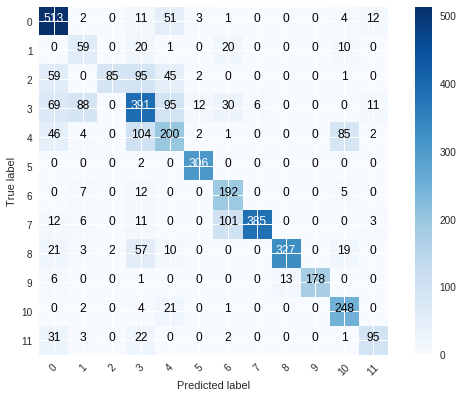

In [0]:


'''
plot confusion matrix
'''
class_names = [i for i in range (12)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):


    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    '''
    labels = classes
    #cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''
    print(cm)
    print ('\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# In[ ]:

print('\n*************Confusion Matrix*********************\n')

verify_gen=ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,
                                 height_shift_range=0.2,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')


verify_flow=verify_gen.flow_from_directory(val_dir,target_size=(240,320), batch_size=32,class_mode='categorical',shuffle=False)



pred = model.predict_generator(verify_flow, 4249//32+1)
predictions = np.argmax(pred, axis=1)



cnf_matrix = confusion_matrix(val_flow.classes, predictions)


# In[ ]:


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

from sklearn import metrics
print ('\n\n')
print (metrics.classification_report(val_flow.classes, predictions))
print ('\n\n')


In [0]:
src_test= 'drive/My Drive/kaggle/ali/'

test_df = pd.read_csv(src_test+'test.csv')
print (test_df.head())
file_list = test_df['img'].tolist()



     img    label
0  0.jpg  defect1
1  1.jpg  defect1
2  2.jpg  defect1
3  3.jpg  defect1
4  4.jpg  defect1


In [0]:
file_list = [f[:-4]+'.png' for f in file_list]
file_list[:5]

['0.png', '1.png', '2.png', '3.png', '4.png']

In [0]:
pred_list = [] 
for f in file_list:
  img = load_img(test_dir+f)
  x = x = img_to_array(img).astype('uint')
  x= x/255.
  img_arr = x.reshape((1,) + x.shape)
  pred = model.predict(img_arr)
  pred_list.append(np.argmax(pred,axis=1))
  
final_predictions = np.array(pred_list)  
print (final_predictions.shape)

(440, 1)


In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(240,320),shuffle=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

print (nb_samples)

pred_cat12 = model.predict_generator(test_flow,nb_samples)
print (len(pred_cat12))

pred_test = np.argmax(pred_cat12,axis=1) + 1  # note 要加  1 回來 starts from 1 to12 (not 0 to 11)
print (pred_test.shape)


Found 432 images belonging to 1 classes.
432


ZeroDivisionError: ignored

In [0]:
src_test= 'drive/My Drive/kaggle/ali/'

test_df = pd.read_csv(src_test+'test.csv')
print (test_df.head())
test_df['label']= final_predictions
test_df.head()


     img    label
0  0.jpg  defect1
1  1.jpg  defect1
2  2.jpg  defect1
3  3.jpg  defect1
4  4.jpg  defect1


,img,label
0,0.jpg,0
1,1.jpg,0
2,2.jpg,4
3,3.jpg,0
4,4.jpg,3


In [0]:

with open(src_test+'label_to_category.pkl', 'rb') as handle:
    label_to_category = pickle.load(handle)


test_df['label'].replace(label_to_category,inplace=True)
test_df

,img,label
0,0.jpg,norm
1,1.jpg,norm
2,2.jpg,defect4
3,3.jpg,norm
4,4.jpg,defect3
5,5.jpg,defect11
6,6.jpg,defect11
7,7.jpg,defect2
8,8.jpg,norm
9,9.jpg,defect5


In [0]:
test_df.to_csv(src_test+'test_submit_fit_generator.csv', header=False,index=False)

In [0]:


'''
build 2nd stage model
# 雀屏中選
'''


train2_data = np.load(src_1+'train_data_MobileNetV2_1_aug_for_1.npy')
print (train2_data.shape)


'''
filter out defcet item from label
get  2nd stage train data and label data note: 2nd stage tarin data will use conv

'''





with open (src_1+'train_label_data_aug_for_1.pkl','rb') as handle:
    train_label_data = pickle.load(handle)
  


#train_x,val_x,train_y,val_y = train_test_split(train2_data,train_label_data,test_size=0.2,shuffle=True)

#print (train_x.shape)


'''  

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)



  
xgb1.fit(train_x,train_y)


from sklearn.metrics import accuracy_score
val_pred = xgb1.predict(val_x)

predictions = [round(value) for value in val_pred]
# evaluate predictions
accuracy = accuracy_score(val_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
  
'''  
  

one_hot_train_label_data = to_categorical(train_label_data - 1)

print (one_hot_train_label_data.shape)







In [0]:
del model
K.clear_session()

In [0]:

train_x,val_x,train_y,val_y = train_test_split(train2_data,one_hot_train_label_data,test_size=0.3,shuffle=True)

# NOW Data ready for training

print (train_x.shape)


def conv_block(ch, strides, activation= 'relu', padding='same',kernel_regularizer=regularizers.l1(0.05)):
    return Conv2D(ch,(3,3), strides=strides, activation= activation, padding =padding , kernel_regularizer= kernel_regularizer)

def build_model_6(ch=32):
    #inputs = Input((IMAGE_HEIGHT,IMAGE_WIDTH,ch))
    inputs = Input((1000,))



    x = Dense(512, activation='relu')(inputs)

    x =Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)

    x =Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)

    x =Dropout(0.3)(x)

    #x = Dense(64, activation='relu')(x)

    #x =Dropout(0.3)(x)


    outputs = Dense(11,activation='softmax')(x)



    model = Model(inputs= inputs, outputs=outputs)
    model.summary()

    return model



model = build_model_6()

model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

#model_6 = load_model(src_1+'conv_for_defect_11_2_final.h5')


checkpoint = ModelCheckpoint(src_save+'dense_3layer_1000_1st.h5')
earlystop = EarlyStopping(monitor='val_loss',  patience=10,  mode='auto')
callback_list = [checkpoint,earlystop]

model.fit(x=train_x, y=train_y, batch_size=32, epochs=300, callbacks=callback_list, verbose=1,  validation_split=0.2, shuffle=True)

model.evaluate(val_x,val_y)

In [0]:
model.evaluate(val_x,val_y)

---

In [0]:

model.save(src_save+'dense_3layer_1000_1st_final.h5')


In [0]:

'''
plot confusion matrix
'''
class_names = [i for i in range (12)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):


    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    '''
    labels = classes
    #cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''
    print(cm)
    print ('\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# In[ ]:

predictions = np.argmax(model.predict(val_x),axis=1)

cnf_matrix = confusion_matrix(np.argmax(val_y,axis=1), predictions)


# In[ ]:


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

from sklearn import metrics
print ('\n\n')
print (metrics.classification_report(np.argmax(val_y,axis=1), predictions))
print ('\n\n')

# Start Testing

In [0]:

"""# Starting doing Testing"""

'''
1st stage
import Data
import ast stage model - xgb
classfiication via xgb1
later wil sue 1st stage classification to filter out test data for 2nd stage classfiication
'''

test1_data = np.load(src_1+'test_data_MobileNetV2_1.npy')



with open (src_1+'xgb_2_stage_MobileNetV2_1_0926.pkl','rb') as handle:
  xgb_stage_1 = pickle.load(handle)


xgb_stage_1



pred_stage_1 = xgb_stage_1.predict(test1_data)

#predictions_stage_1 = [round(value) for value in pred_stage_1]

#print (len(predictions_stage_1))
print (pred_stage_1[:10])

# note: predict = 1 measn '正常' or non-dfect

failure_list= (pred_stage_1 == 0)



test2_data = np.load(src_1+'test_data_MobileNetV2_1.npy')
test2_data.shape


test2_data_2 = test2_data[failure_list]    # test_data2 = defect list in test data set (later will make inferefing )
test2_data_2.shape

model = load_model(src_1+'2nd_stage_dense_MobileNetV2_2_0926.h5')


pred_stage_2 = model.predict(test2_data_2)

#predictions_stage_1 = [round(value) for value in pred_stage_1]

print (pred_stage_2.shape)

pred_stage_2_2 = np.argmax(pred_stage_2,axis=1) + 1  # note 要加  1 回來 starts from 1 to12 (not 0 to 11)
print (pred_stage_2_2.shape)

print (pred_stage_2_2[:10])


'''
make submit csv
read sample test csv  from original add header 'img', 'label'
replace 'label' as first predict
change 0 to 20 (use 20 to distiguish from other label data, just means it is defect
change 1 to 0  (1 measn normal, needs to change back to category 0)
'''

# read test csv file
test_df = pd.read_csv(src_1+'test.csv')
test_df['label']= pred_stage_1
test_df.loc[test_df['label']==0,'label']=20
test_df.loc[test_df['label']==1,'label']=0



'''
replace defect rows with 2nd staget prediction
'''
test_df_2 =  test_df['label']
test_df_2[test_df_2 == 20] = pred_stage_2_2


test_df['label'] = test_df_2


'''
change form 0,11 to category name
'''

with open(src_1+'label_to_category.pkl', 'rb') as handle:
    label_to_category = pickle.load(handle)


test_df['label'].replace(label_to_category,inplace=True)
test_df

In [0]:



# save csv file for submit (using 2  satge )

test_df.to_csv(src_1+'test_submit_2_st_0926_no__doubt.csv', header=False,index=False)
